## Exploring Rat Dataset

Notebook for exploring rat dataset, writing import functions etc.

February 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib 
import platform
sns.set_context("talk")


In [2]:
if platform.system() == "Windows":
    DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
else:
    DATA_PATH = pathlib.Path("/Volumes/brody/jbreda/learning_project/data" )
F_NAME = "rat_behavior.csv"
ANIMAL_ID = "W080"

#### Load CSV -> DF

In [3]:
DATA_PATH/F_NAME

PosixPath('/Volumes/brody/jbreda/learning_project/data/rat_behavior.csv')

In [5]:
RAT_DF = pd.read_csv(DATA_PATH/F_NAME)

In [6]:
RAT_DF["violation"] = RAT_DF.hit.isnull()
RAT_DF.subject_id = RAT_DF.subject_id.astype("string")
RAT_DF.head()

,subject_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage,violation
0,W051,1,1,NaN,NaN,1.0,0,0.0,1.00,1,False
1,W051,2,1,NaN,NaN,1.0,0,0.0,0.01,1,False
2,W051,2,2,NaN,NaN,0.0,0,1.0,0.01,1,False
3,W051,2,3,NaN,NaN,0.0,1,0.0,0.01,1,False
4,W051,2,4,NaN,NaN,1.0,0,0.0,0.01,1,False


In [7]:
W080_df = RAT_DF.query('subject_id == @ANIMAL_ID').reset_index(drop=True)

In [8]:
W080_df.head()

,subject_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage,violation
0,W080,1,1,NaN,NaN,0.0,0,1.0,0.01,1,False
1,W080,1,2,NaN,NaN,1.0,0,0.0,0.01,1,False
2,W080,1,3,NaN,NaN,1.0,0,0.0,0.01,1,False
3,W080,1,4,NaN,NaN,0.0,0,1.0,0.01,1,False
4,W080,1,5,NaN,NaN,0.0,1,0.0,0.01,1,False


In [9]:
W080_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97696 entries, 0 to 97695
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      97696 non-null  string 
 1   session         97696 non-null  int64  
 2   trial           97696 non-null  int64  
 3   s_a             89491 non-null  float64
 4   s_b             89491 non-null  float64
 5   choice          78540 non-null  float64
 6   correct_side    97696 non-null  int64  
 7   hit             78540 non-null  float64
 8   delay           97696 non-null  float64
 9   training_stage  97696 non-null  int64  
 10  violation       97696 non-null  bool   
dtypes: bool(1), float64(5), int64(4), string(1)
memory usage: 7.5 MB


## Sessions & Stage

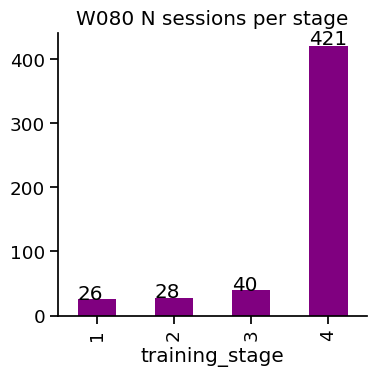

In [9]:
sns.set_context("notebook", font_scale=1.2)
ax = (W080_df.groupby("training_stage")
 .max()
 .session
 .plot.bar(
    title=f"{ANIMAL_ID} N sessions per stage",
    figsize=(4,4),
    color = 'purple'
    )
)
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() * 1, 
                 p.get_height() * 1.005))

sns.despine()
plt.tight_layout()

[Text(0.5, 1.0, 'W080 Trials Per Session ~ Training Stage')]

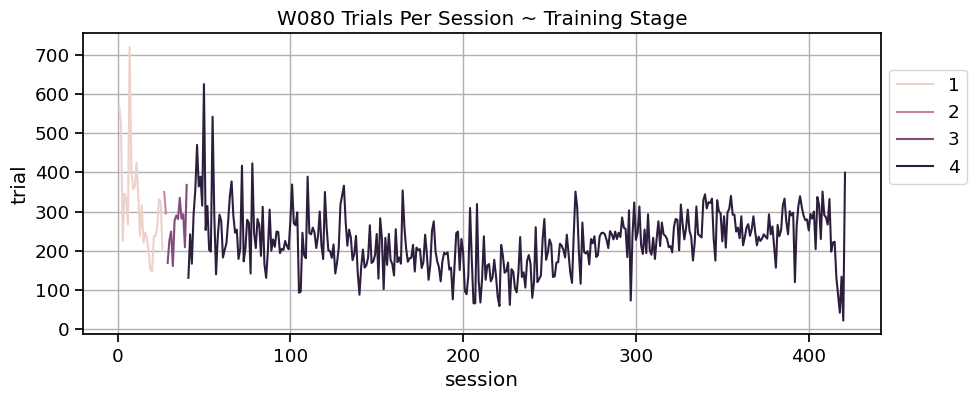

In [10]:
fig,ax = plt.subplots(figsize = (10,4))
sns.lineplot(
    data=W080_df.groupby("session").max(), 
    x="session", y="trial", hue ="training_stage"
    )

plt.grid()
plt.legend(loc=(1.01,0.5))
plt.tight_layout()
ax.set(title=f"{ANIMAL_ID} Trials Per Session ~ Training Stage")

In [23]:
sns.palettes

<module 'seaborn.palettes' from '/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/palettes.py'>

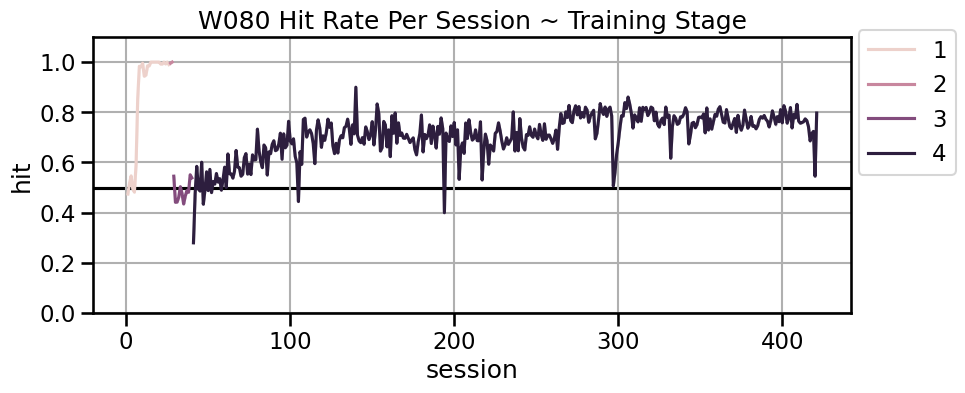

In [22]:
fig,ax = plt.subplots(figsize = (10,4))
sns.lineplot(
    data=W080_df, x="session", y ="hit", 
    hue="training_stage", errorbar=['ci', False]
    )

plt.grid()
plt.axhline(y=0.5,zorder=1, color='k')
plt.legend(loc=(1.01,0.5))
plt.ylim(0,1.1)
plt.tight_layout()
_= ax.set(title=f"{ANIMAL_ID} Hit Rate Per Session ~ Training Stage")


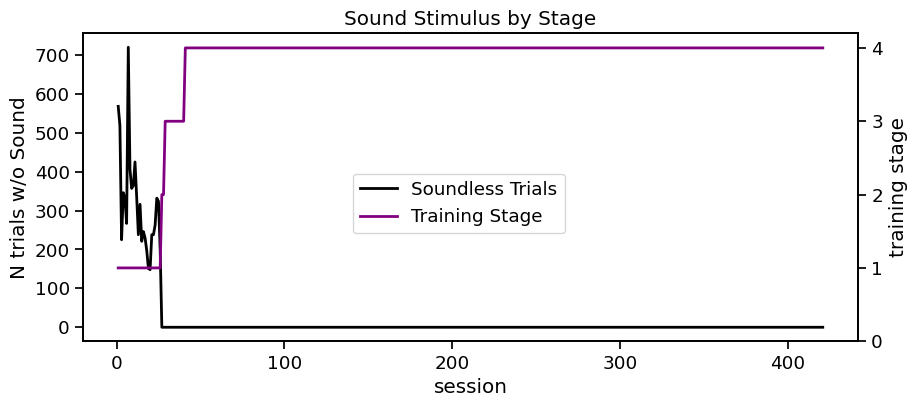

In [12]:
fig,ax = plt.subplots(figsize = (10,4))

sns.lineplot(
    W080_df["s_a"].isnull().groupby(W080_df['session']).sum(),
    ax=ax, color = "black", linewidth=2,
    label= "Soundless Trials", legend=False
    )

ax2=plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2, color="purple", linewidth=2,
    label="Training Stage", legend=False
    )

ax.set(ylabel= "N trials w/o Sound", title="Sound Stimulus by Stage")
ax2.set(ylabel= "training stage",ylim=(0, 4.2))
fig.legend(loc="center")



## Mistrials

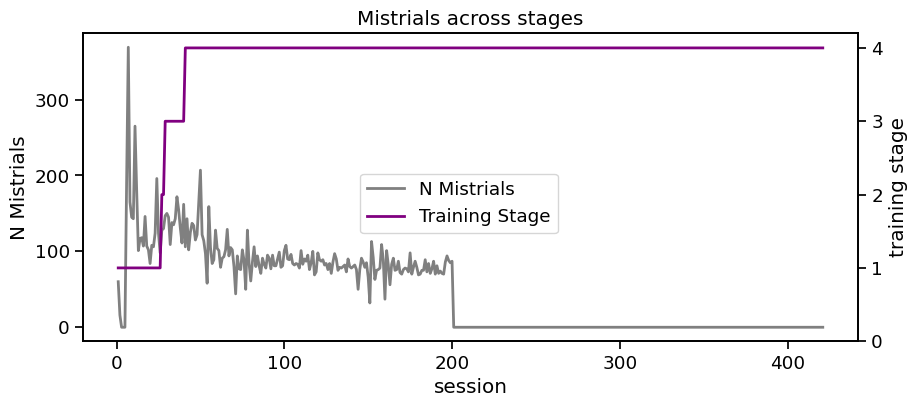

In [13]:
fig,ax = plt.subplots(figsize = (10,4))

sns.lineplot(
    W080_df["hit"].isnull().groupby(W080_df['session']).sum(),
    ax=ax, color = "gray", linewidth=2,
    label= "N Mistrials", legend=False
    )

ax2=plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2, color="purple", linewidth=2,
    label="Training Stage", legend=False
    )

ax.set(ylabel= "N Mistrials", title="Mistrials across stages")
ax2.set(ylabel= "training stage",ylim=(0, 4.2))
fig.legend(loc="center")


# Session for violation cut off

In [14]:
def determine_session_violation_drop(animal_df, threshold=30):
    null_counts = animal_df['hit'].isnull().groupby(animal_df['session']).sum()
    mask = (null_counts.index > threshold) & (null_counts == 0)
    return mask.argmax() # first session where there is 0 violations

def determine_stage_violation_drop(animal_df, session_drop):
    return animal_df.query(f'session == {session_drop}').training_stage.max()

def determine_average_hits_violation_drop(animal_df, session_drop, window=10):
    # get performance for the 10 sessions leading up to the drop
    return animal_df.query(f'session > {session_drop-window} & session < {session_drop+1}').hit.mean()

def determine_average_viols_violation_drop(animal_df, session_drop, window=10):
    # get performance for the 10 sessions leading up to the drop
    return animal_df.query(f'session > {session_drop-window} & session < {session_drop+1}').violation.mean()

In [15]:
viol_df = RAT_DF.groupby("subject_id").apply(lambda group: pd.Series({
    "animal_id": group.name,
    "session_viol_drop": determine_session_violation_drop(group),
    "stage_viol_drop": determine_stage_violation_drop(group, determine_session_violation_drop(group)),
    "hit_viol_drop": determine_average_hits_violation_drop(group, determine_session_violation_drop(group),window=10),
    "viol_viol_drop": determine_average_viols_violation_drop(group, determine_session_violation_drop(group),window=10),
})).reset_index(drop=True)



In [16]:
viol_df

,animal_id,session_viol_drop,stage_viol_drop,hit_viol_drop,viol_viol_drop
0,W051,196,4,0.631285,0.272780
1,W060,199,4,0.751385,0.122722
2,W061,200,4,0.667571,0.199348
3,W062,199,4,0.614017,0.311239
4,W065,199,4,0.781170,0.239257
5,W066,199,4,0.749636,0.193662
6,W068,200,4,0.678503,0.205542
7,W072,193,4,0.768262,0.294013
8,W073,193,4,0.702462,0.318097
9,W074,200,4,0.802278,0.100604


(0.0, 230.0)

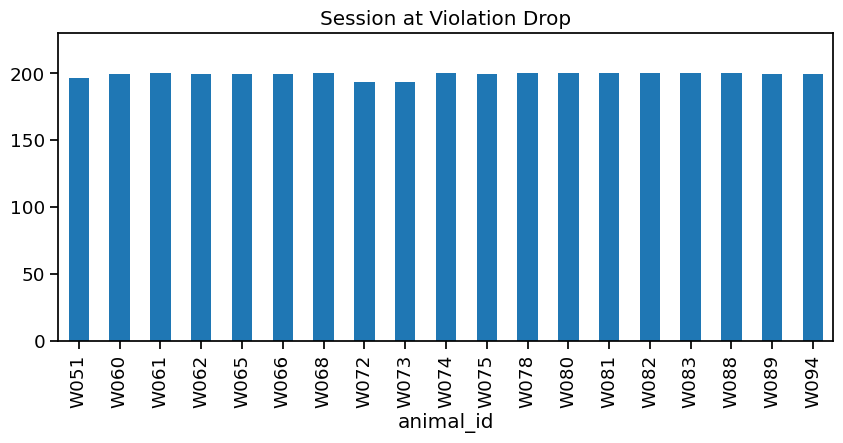

In [17]:
fig,ax = plt.subplots(figsize = (10,4))
viol_df.plot(kind="bar", x="animal_id", y="session_viol_drop", title="Session at Violation Drop", legend=False,ax=ax)
plt.ylim(0,230)

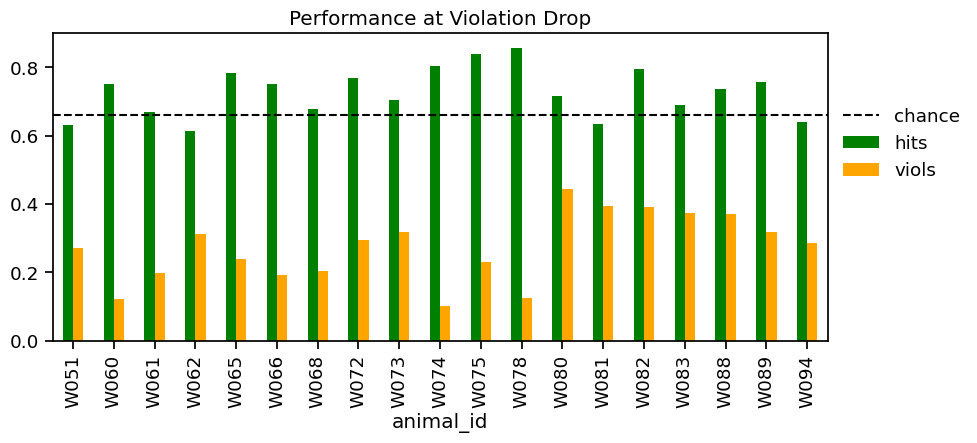

In [18]:
fig,ax = plt.subplots(figsize = (10,4))
viol_df.plot(kind="bar", x="animal_id", y=["hit_viol_drop", "viol_viol_drop"],
             color=['green', 'orange'], label=["hits", "viols"],legend=True, title="Performance at Violation Drop",ax=ax)

ax.axhline(y=0.66, color='k', linestyle='--', zorder=1, label="chance")
ax.legend(loc=(1.01,0.5), frameon=False)

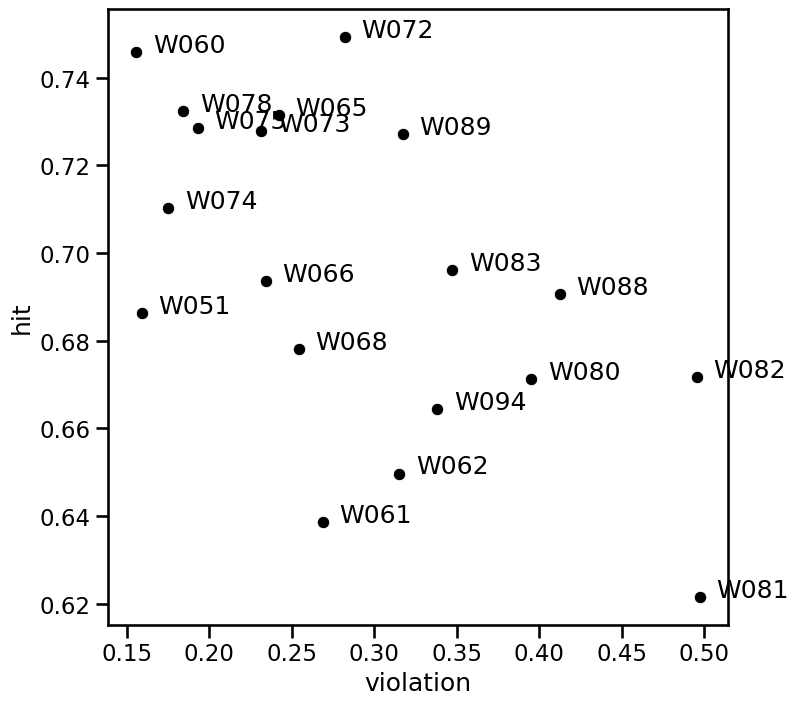

In [30]:
fig,ax = plt.subplots(figsize = (8,8))
rat_df_w_viols = RAT_DF.query('session <= 200')
group = rat_df_w_viols.groupby("subject_id").mean()
sns.scatterplot(
    x=group["violation"],
    y=group["hit"],
    color="k",
    ax=ax
)
for index, row in group.iterrows():
    ax.text(row["violation"] + 0.01, row["hit"], str(index))

[(0.0, 1.0), (0.0, 1.0)]

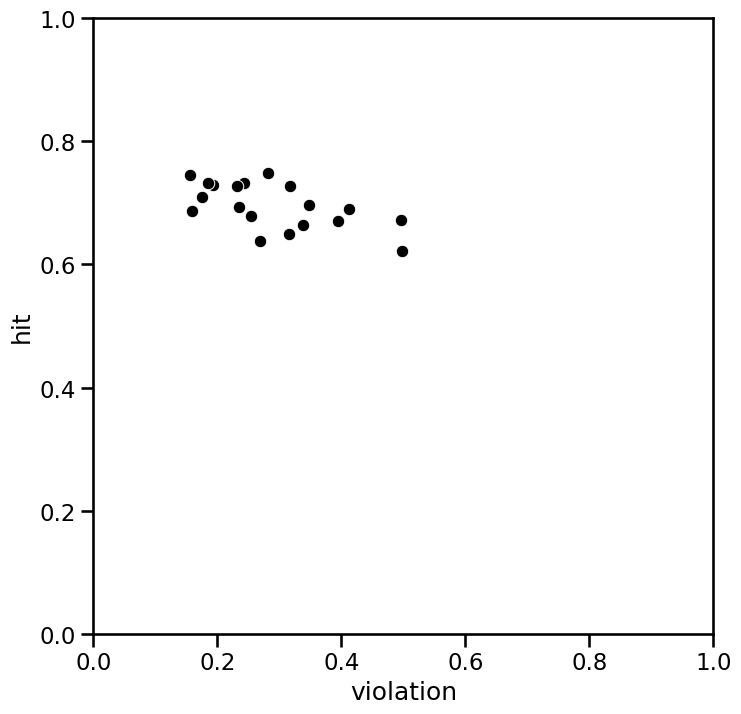

In [29]:
fig,ax = plt.subplots(figsize = (8,8))
rat_df_w_viols = RAT_DF.query('session <= 200')
group = rat_df_w_viols.groupby("subject_id").mean()
sns.scatterplot(
    x=group["violation"],
    y=group["hit"],
    color="k",
    ax=ax
)
# for index, row in group.iterrows():
#     ax.text(row["violation"] + 0.01, row["hit"], str(index))
ax.set(ylim=(0,1), xlim=(0,1))
# plt.text(group.index, (group["violation"], group["hit"]))

## Delays

Plot 1 - number of unique delay lengths by stage per animal


In [10]:
# want to plot the number of unique delay values by stage for each animal
RAT_DF['training_stage_cat'] = RAT_DF['training_stage'].astype('category')

# get unique delay values for each animal
unique_delays = RAT_DF.groupby(["subject_id", "training_stage_cat"]).delay.unique().reset_index()

# get the number of unique delay values for each animal
unique_delays["n_unique_delays"] = unique_delays.delay.apply(lambda x: len(x))

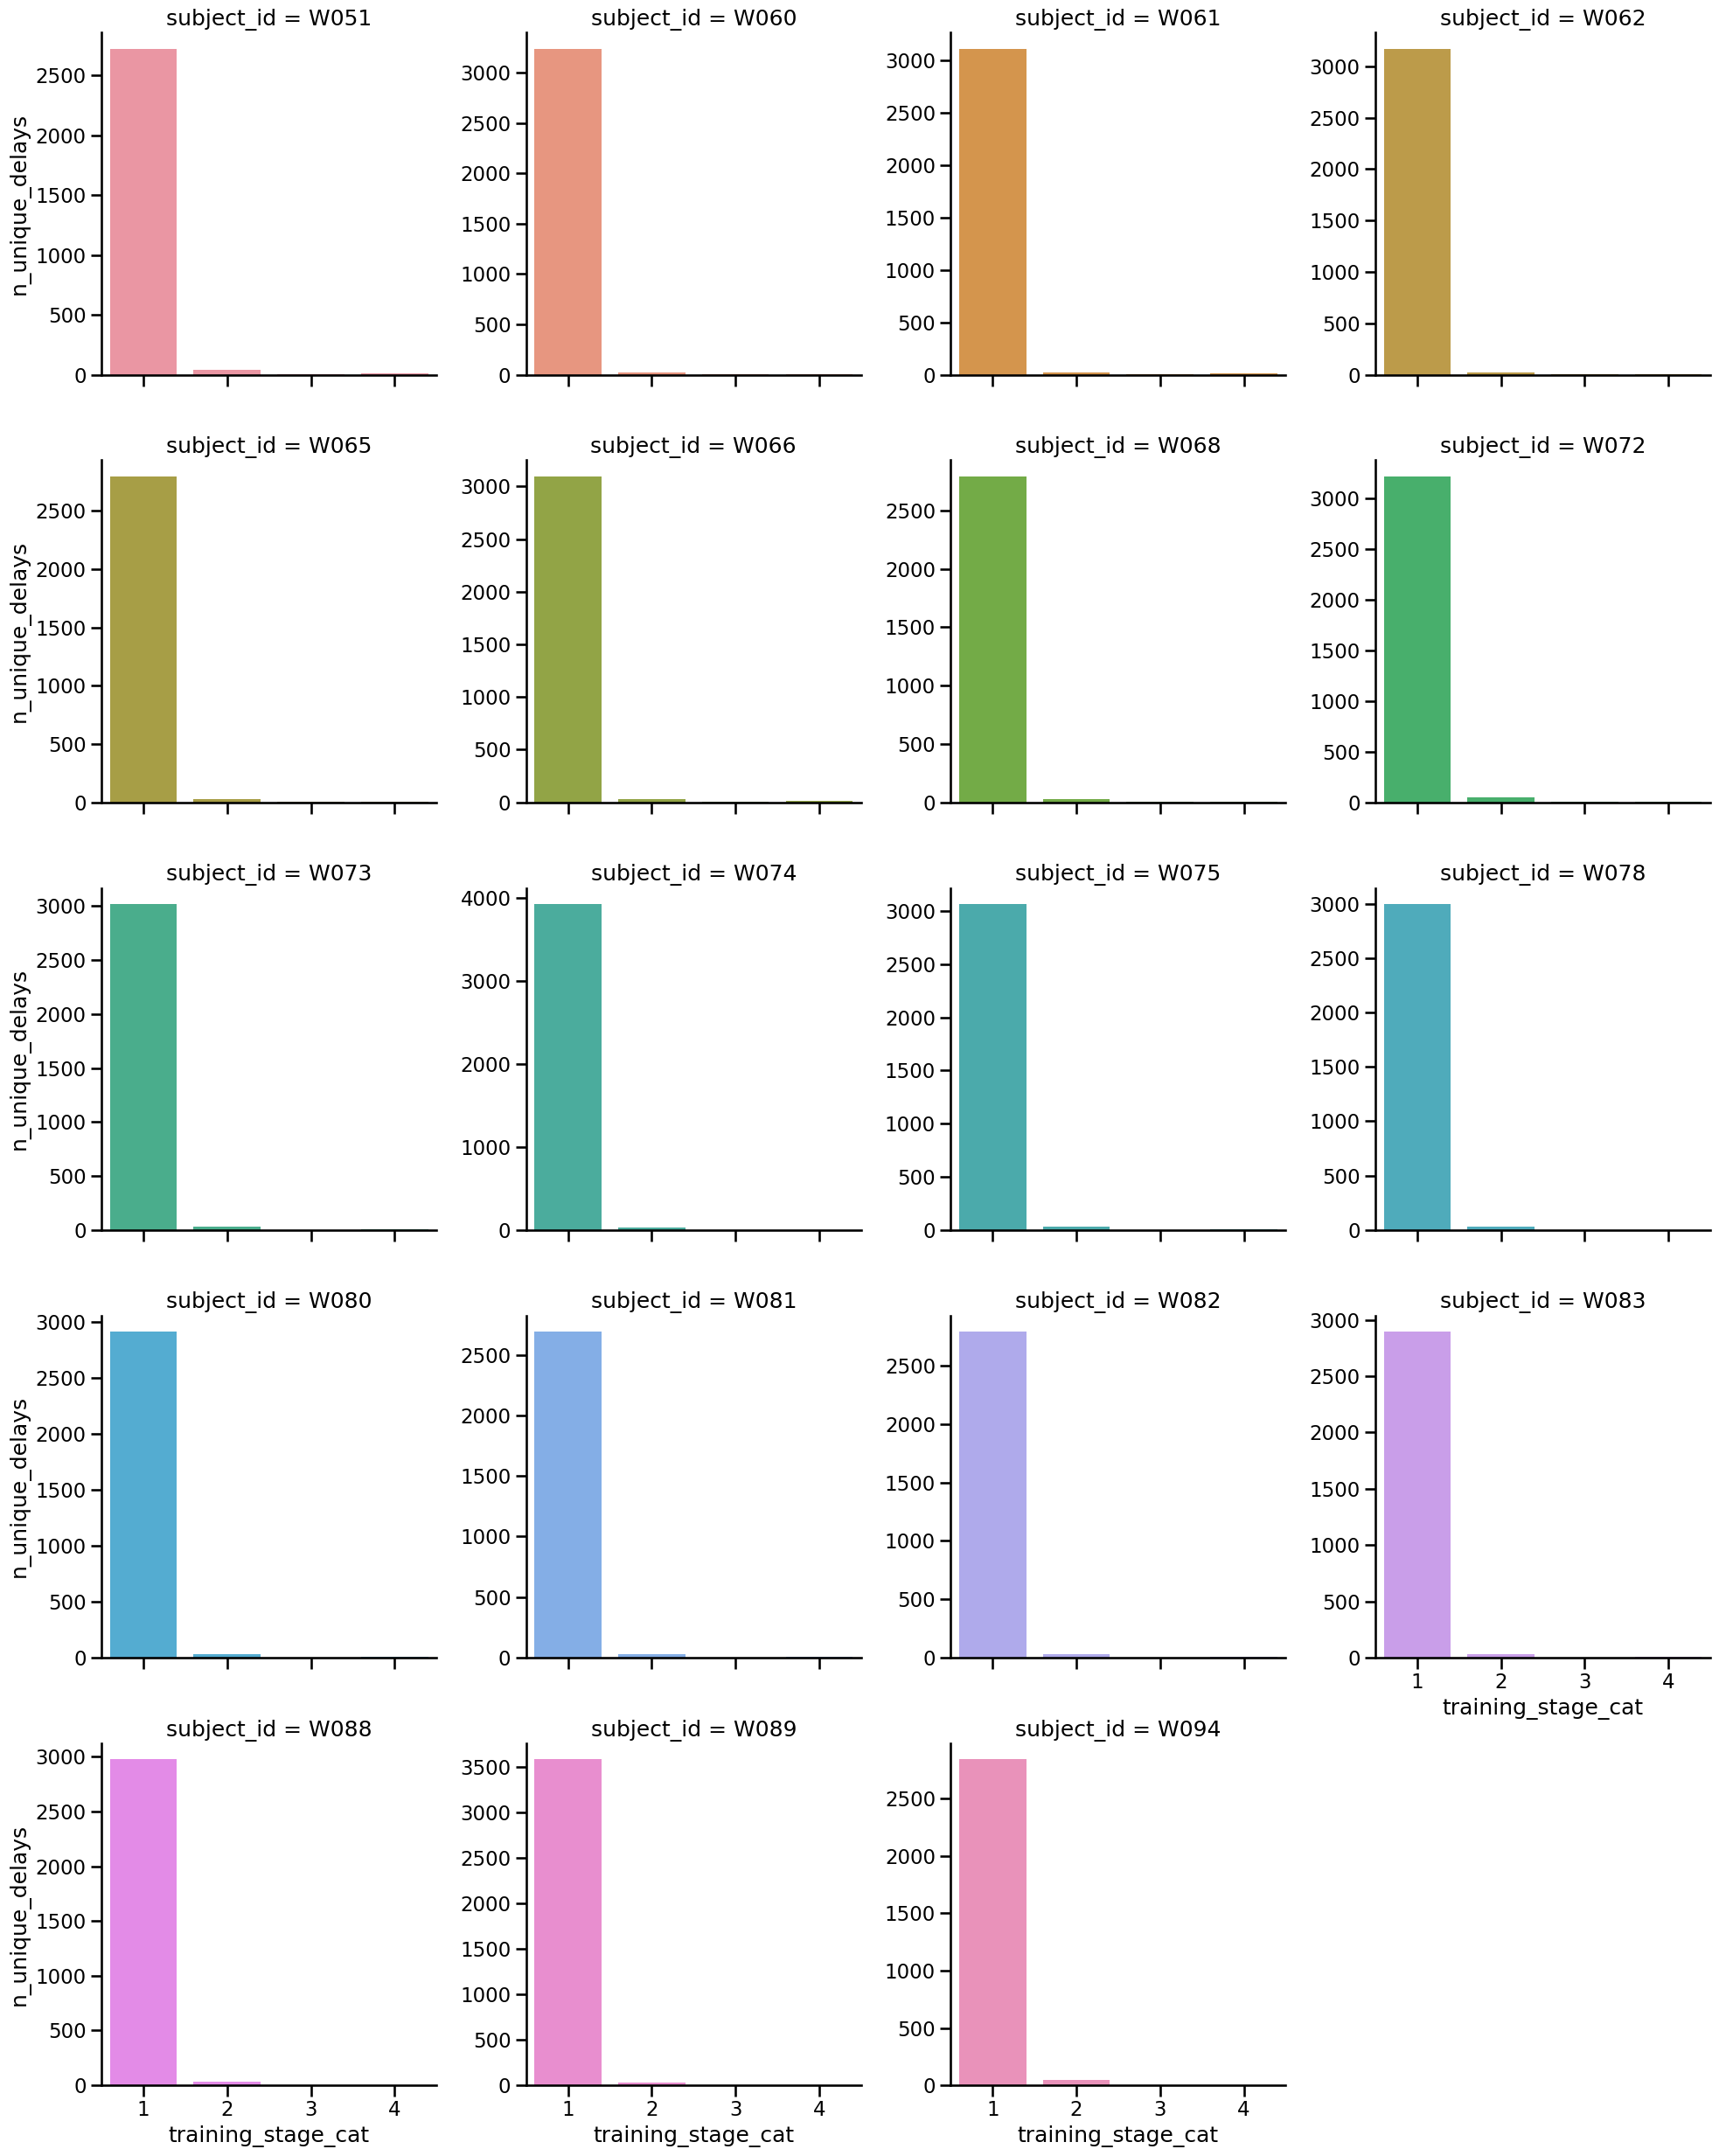

In [11]:
g = sns.catplot(
    x="training_stage_cat", 
    y="n_unique_delays", 
    col="subject_id", 
    col_wrap=4, 
    hue="subject_id", 
    data=unique_delays, 
    kind="bar", 
    dodge=False,
    sharey=False
)


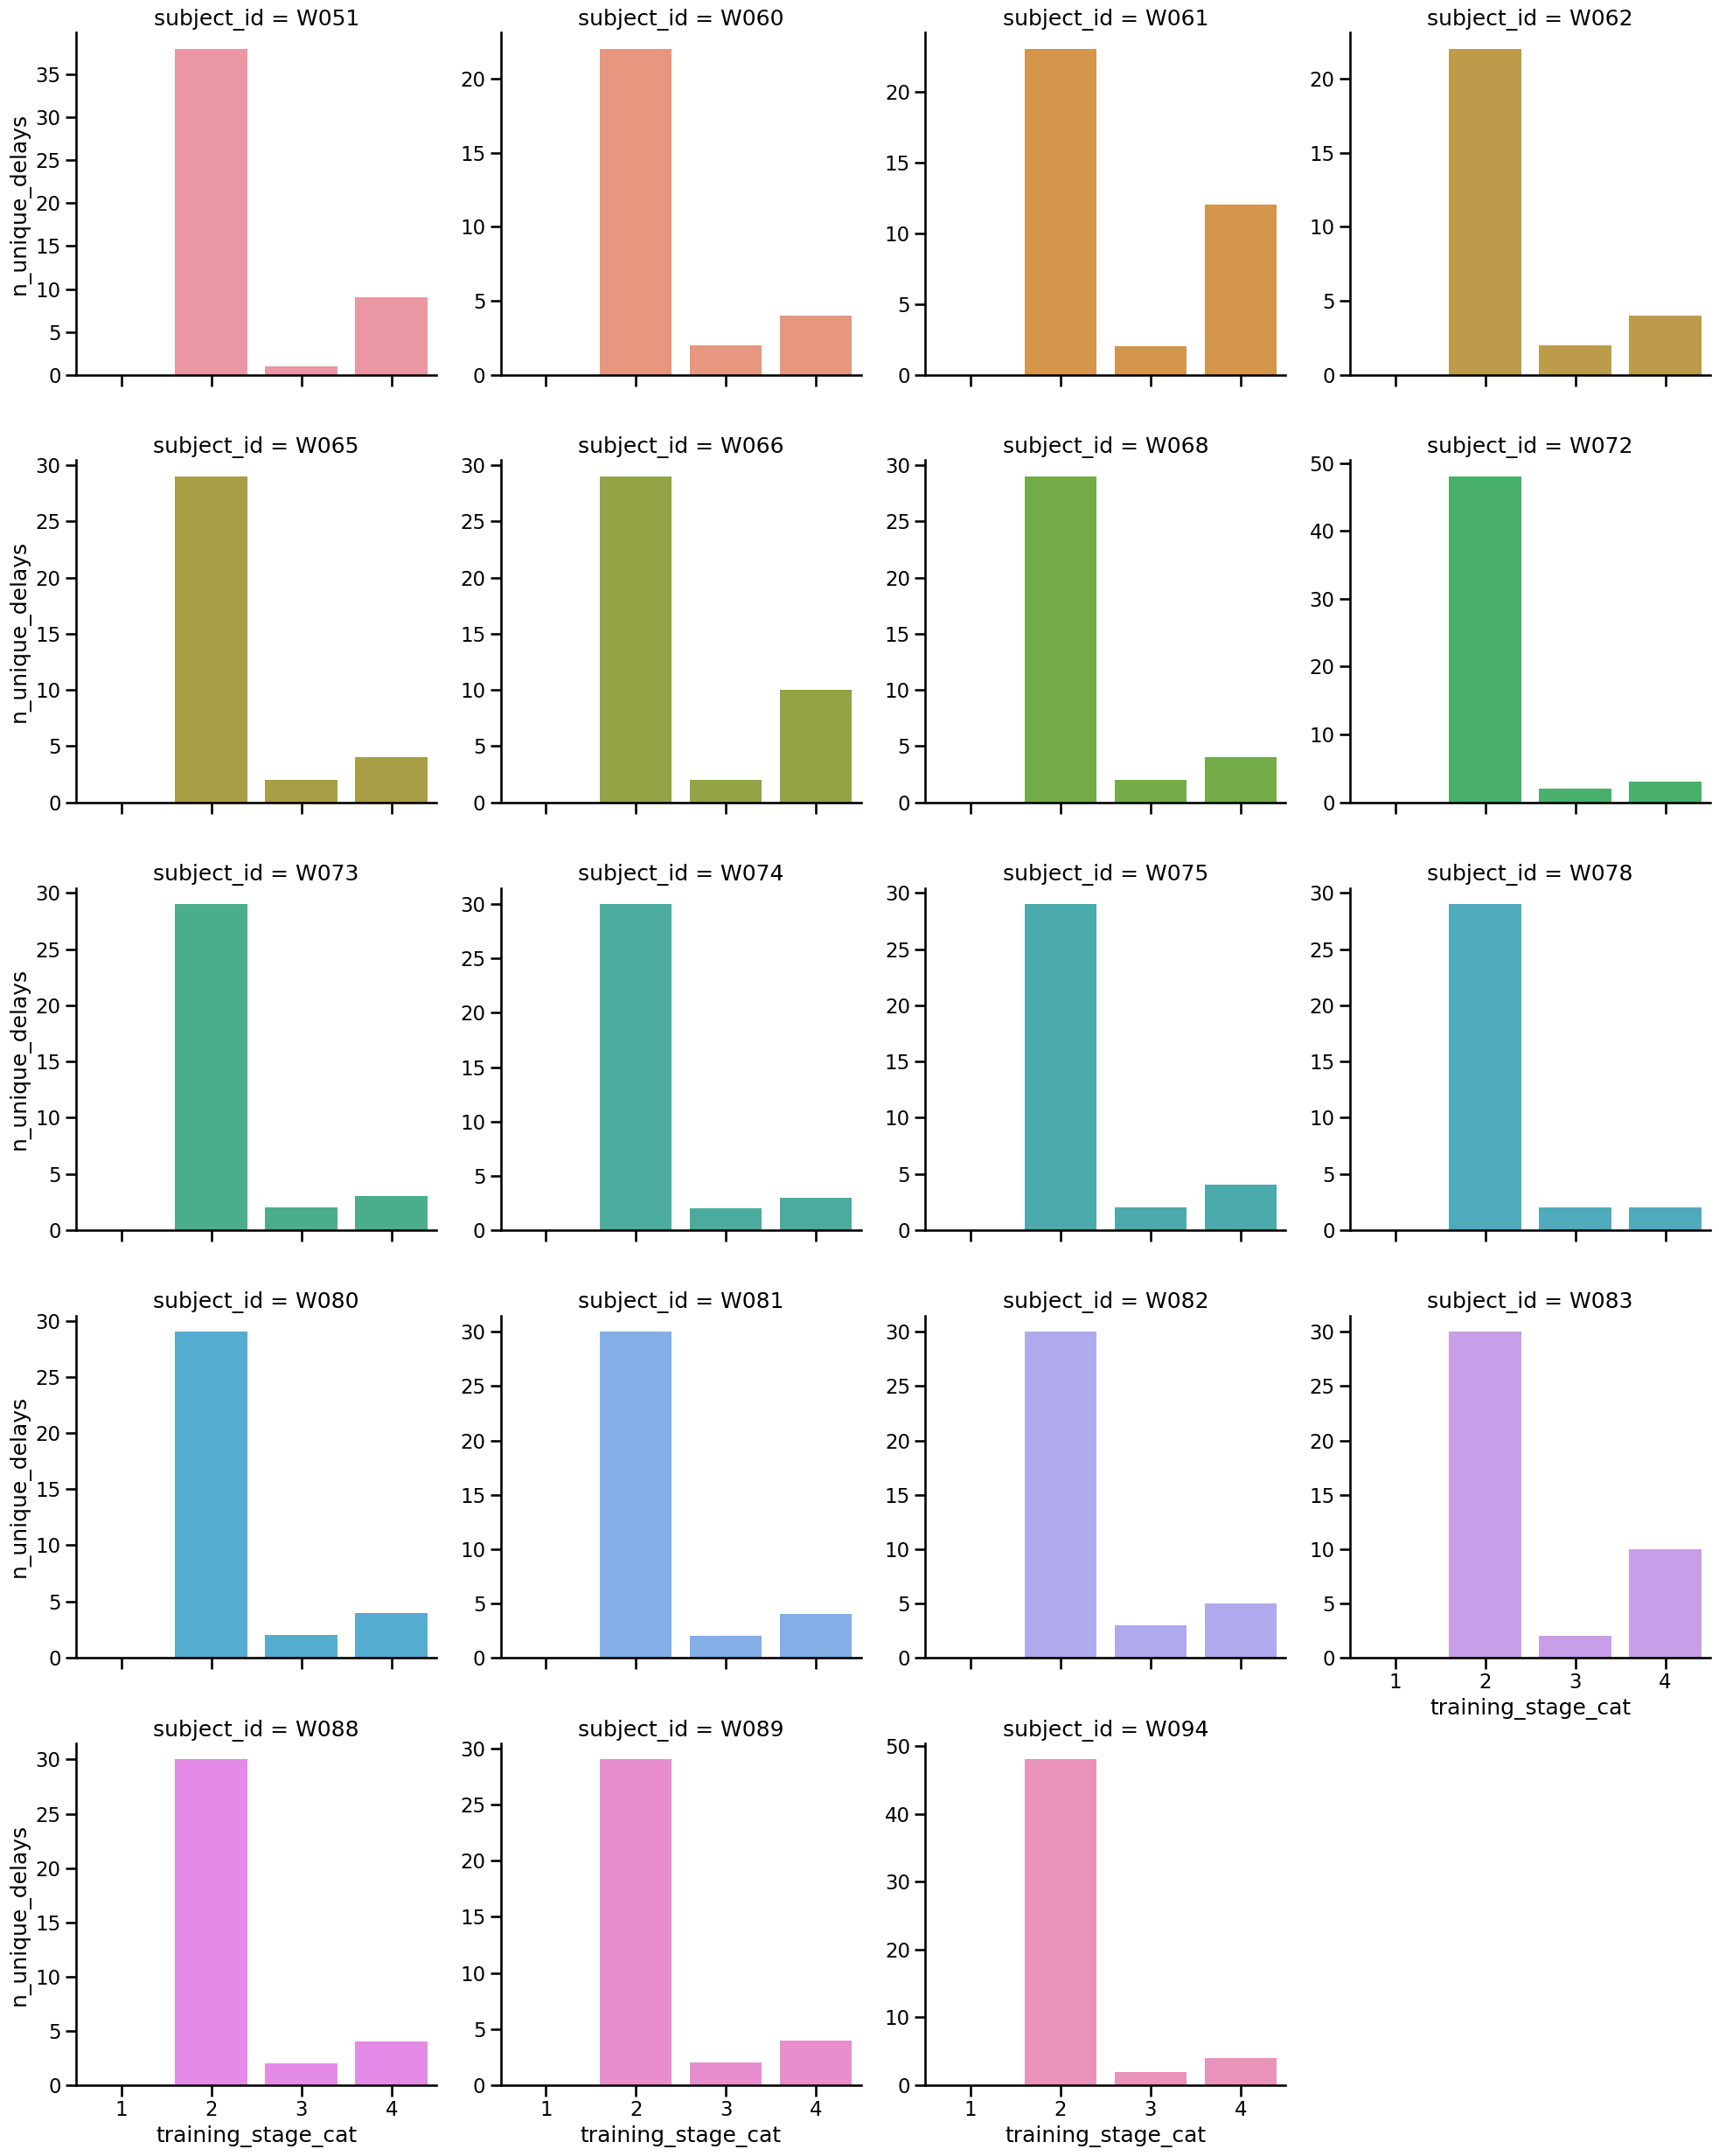

In [12]:
g = sns.catplot(
    x="training_stage_cat", 
    y="n_unique_delays", 
    col="subject_id", 
    col_wrap=4, 
    hue="subject_id", 
    data=unique_delays.query('training_stage_cat != 1'), 
    kind="bar", 
    dodge=False,
    sharey=False

)



Plot 2- delay count colored by stage per animal

In [13]:
rat_df_filtered = RAT_DF[RAT_DF['subject_id'].isin(['W083', 'W080', 'W089', 'W094'])]
delay_params_df = RAT_DF.groupby(["subject_id", "training_stage_cat", "session"]).delay.agg(["min", "max", "median"]).reset_index()


Plotting average delay across sessions for each animal colored by training stage.

Things to note
* stage 1 is primary growth
* stage 2 is very short
* sometimes animals get sent back breifly to stage 1, e.g. W060
* stage 3 is quite stable
* stage 4 is the largest amount of time and the delay parameters change during it

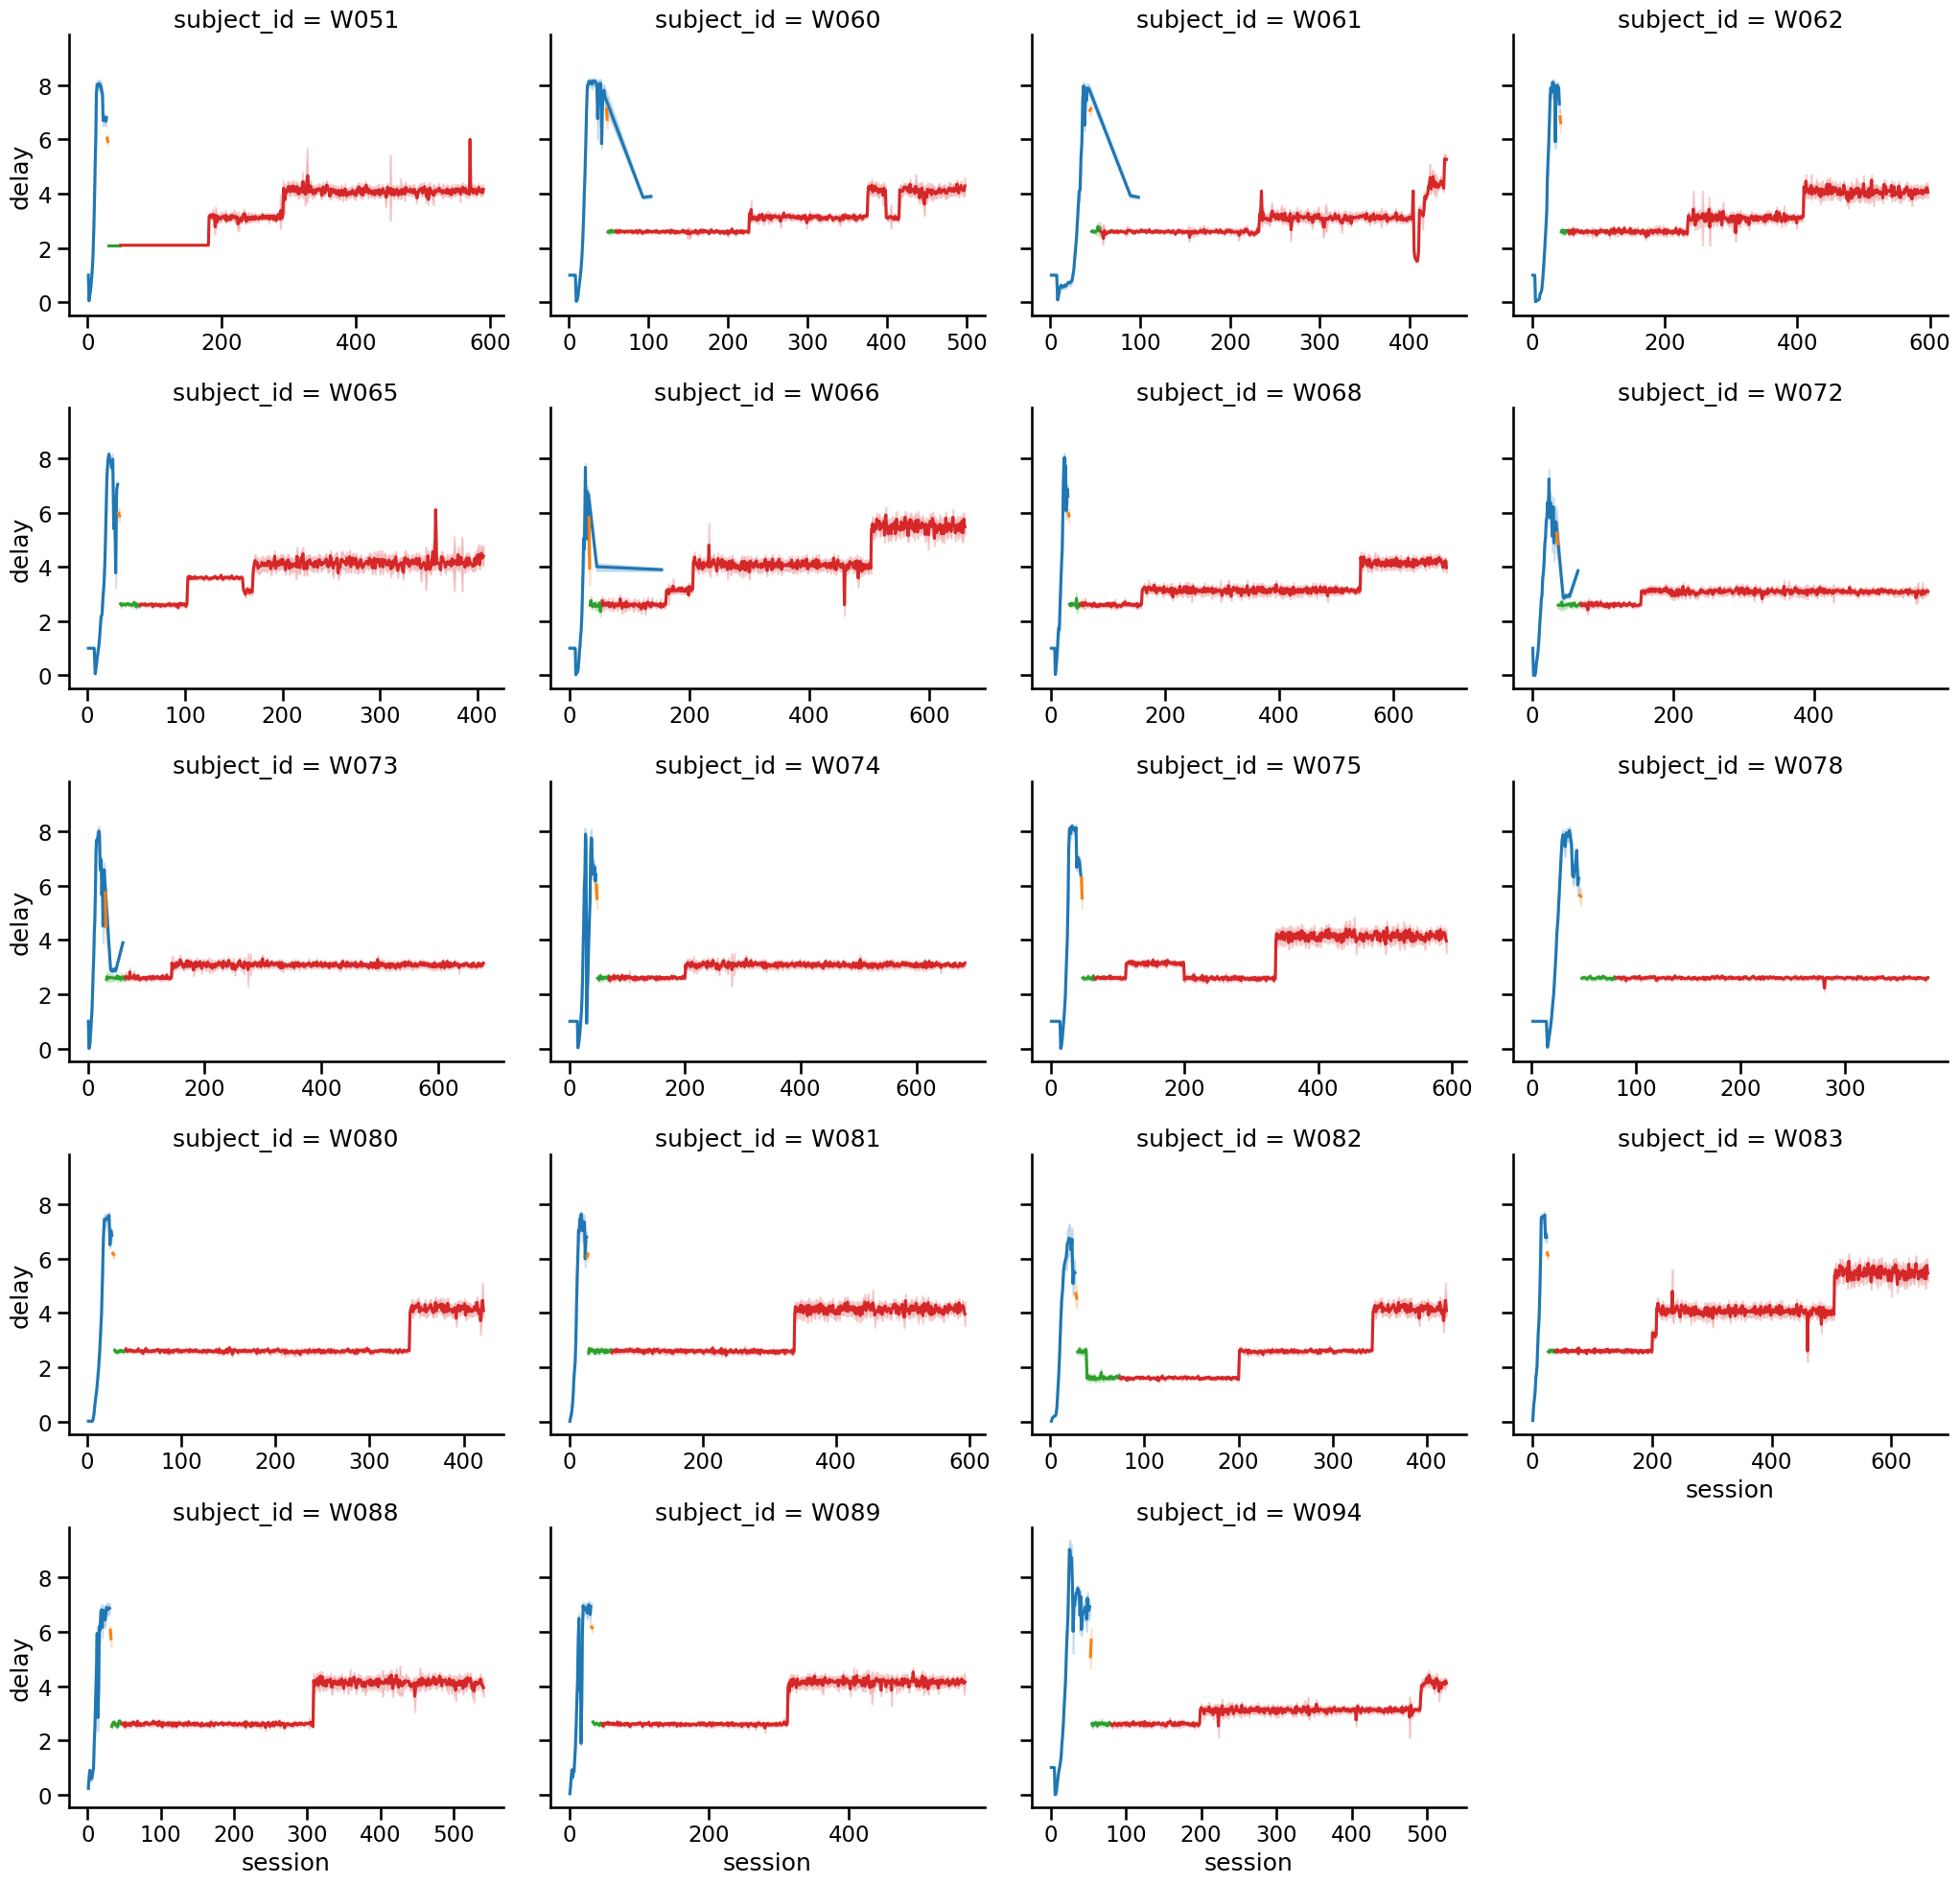

In [31]:
g = sns.FacetGrid(
    data=RAT_DF, 
    col="subject_id", 
    hue="training_stage",  
    col_wrap=4, 
    height=4, 
    aspect=1.3,
    sharey=True,
    sharex=False
)
g.map(sns.lineplot, "session", "delay")


Plot 4- all delays over time per animal

TODO x axis scaling is weird

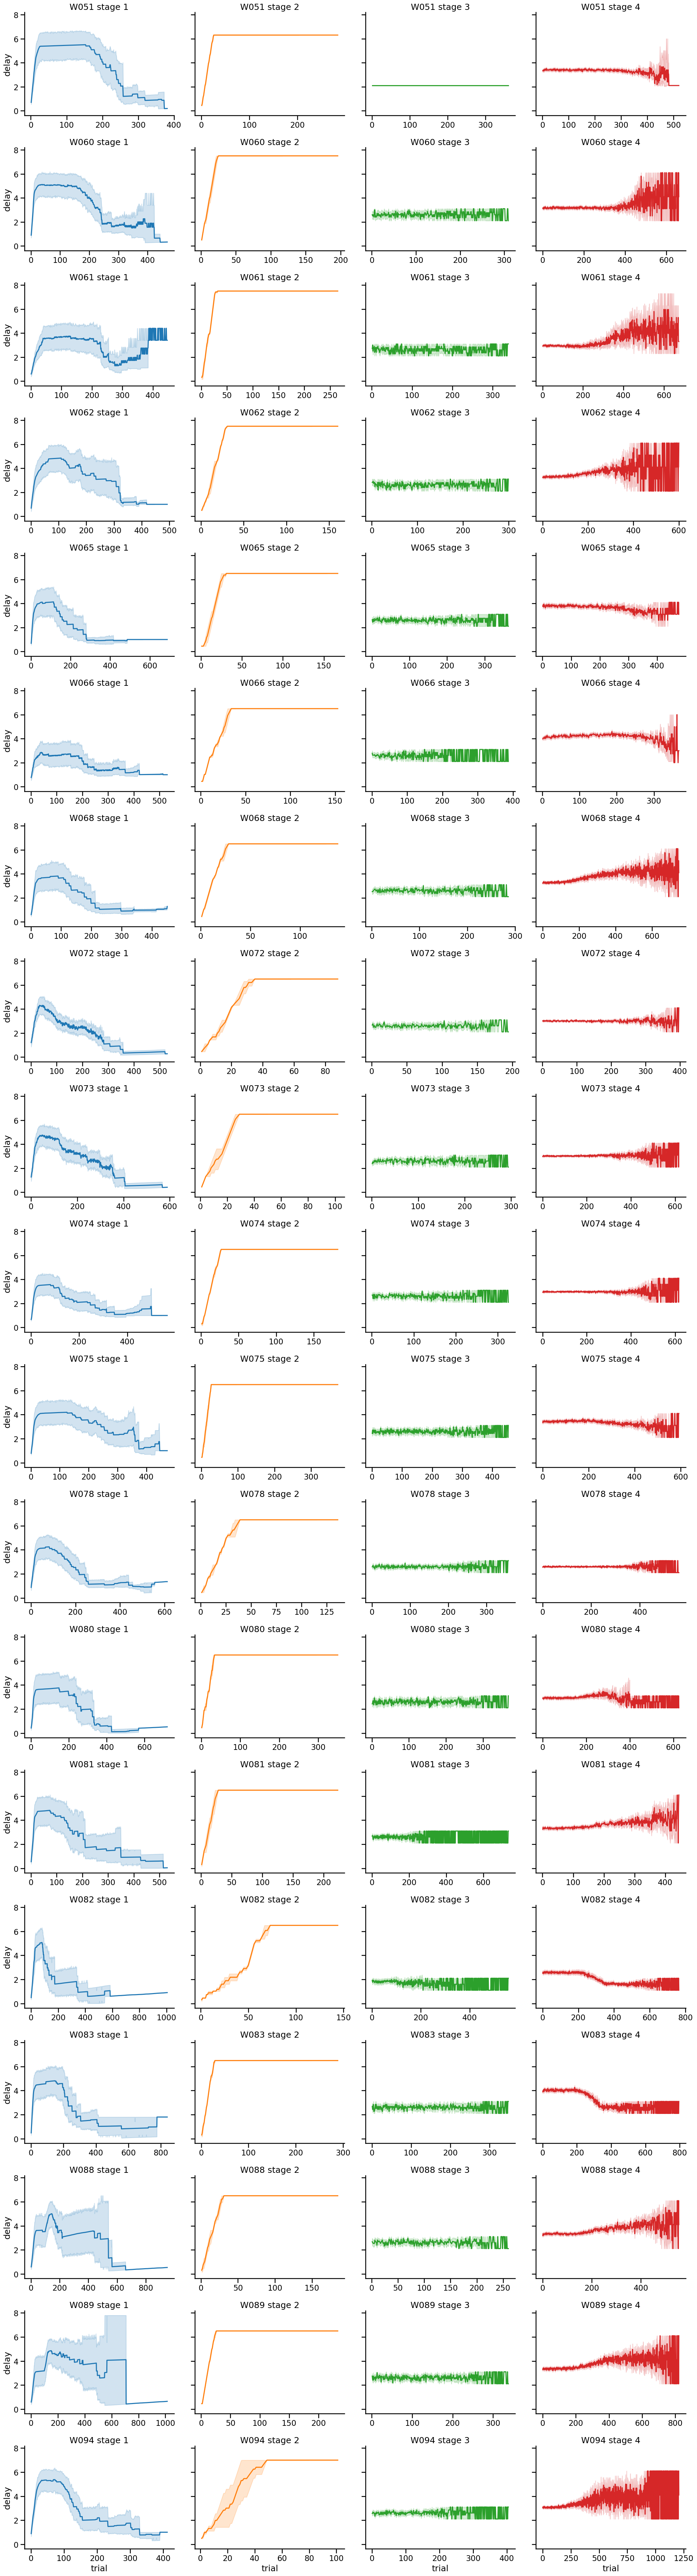

In [38]:
g = sns.FacetGrid(
    data=RAT_DF,
    row="subject_id",
    col="training_stage_cat",
    hue="training_stage_cat",
    sharey=True,
    sharex=False,
    height=4,
    aspect=1.3
)
g.map(sns.lineplot, "trial", "delay")
g.set_titles("{row_name} stage {col_name}")

Plot 4- Histogram of delay times per stage


In [ ]:
# HISTOGRAM HERE

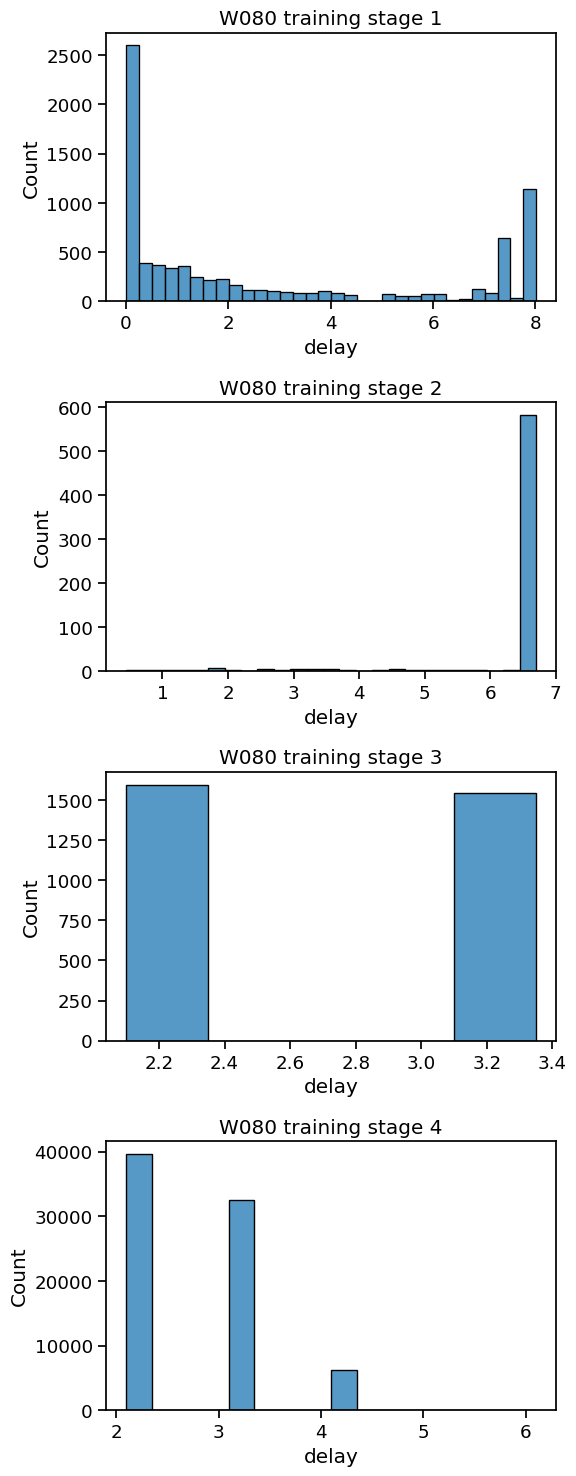

In [ ]:

fig, ax = plt.subplots(4,1, figsize=(6,15))
for ii, (ts, sub_df) in enumerate(W080_df.groupby("training_stage")):
    sns.histplot(sub_df.delay, binwidth=0.25, ax=ax[ii]).set(title=f"{ANIMAL_ID} training stage {ts}")
        
plt.tight_layout()

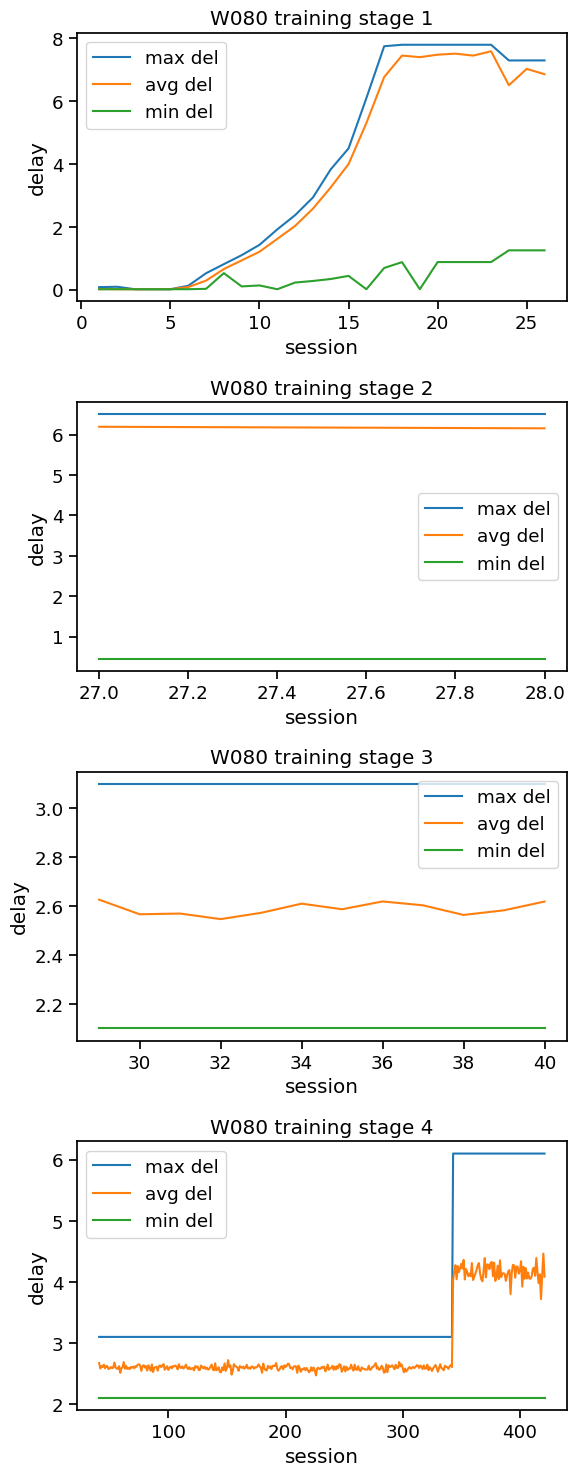

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(6,15))
for ii, (ts, sub_df) in enumerate(W080_df.groupby("training_stage")):
    sns.lineplot(
        sub_df.groupby("session").delay.max(), 
        label="max del", ax=ax[ii] 
        ).set(title=f"{ANIMAL_ID} training stage {ts}")
    sns.lineplot(
        sub_df.groupby("session").delay.mean(), 
        label="avg del", ax=ax[ii] 
        ).set(title=f"{ANIMAL_ID} training stage {ts}")
    sns.lineplot(
        sub_df.groupby("session").delay.min(), 
        label="min del", ax=ax[ii]
        )
plt.tight_layout()

## Sound Pairs

In [ ]:
W080_df.groupby(["s_a", "s_b"]).size().reset_index().rename(columns={0:'count'})

,s_a,s_b,count
0,60.0,68.0,14436
1,68.0,60.0,10247
2,68.0,76.0,8863
3,68.5,76.0,345
4,71.5,76.0,347
5,74.5,76.0,363
6,76.0,68.0,10176
7,76.0,84.0,8952
8,77.5,76.0,396
9,80.5,76.0,383
